In [28]:
#| default_exp preprocessing.lesson16

# Lesson16 Scripts
> Reproducing lesson 16

In [58]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
#| export
from cv_tools.core import *


# Basic Callback Learner

In [98]:
#| export
import torch.optim as optim
import torch
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import default_collate
from torcheval.metrics import Mean, MulticlassAccuracy
import matplotlib.pyplot as plt

In [61]:
#| export
from datasets import load_dataset
from fastcore.all import *
from fastprogress import progress_bar, master_bar


In [62]:
#| export
from operator import attrgetter
from collections.abc import Mapping
from operator import itemgetter
from copy import copy
from contextlib import contextmanager


In [63]:
#| export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [78]:
#| export
@inplace
def transformi(b):
    b['image'] = [torch.flatten(TF.to_tensor(o)) for o in b['image']]

In [65]:
#| export
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [66]:
#| export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [67]:
#| export
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

In [68]:
#| export
class with_cbs:
	"Decorator to add callbacks to a function."
	def __init__(self, nm): self.nm = nm
	def __call__(self, f):
		"Call the function with the callbacks."
		def _f(o, *args, **kwargs):
			"Try to run the function with the callbacks."
			try:
				# First, we call the callback function with the name 'before_' followed by the name of the function we're decorating.
				# This allows us to execute any necessary setup or preprocessing before the function is called.
				o.callback(f'before_{self.nm}')
				# Next, we call the original function with the provided arguments and keyword arguments.
				# This is where the actual work of the function is done.
				f(o, *args, **kwargs)
				# Finally, we call the callback function again, this time with the name 'after_' followed by the name of the function.
				# This allows us to execute any necessary cleanup or postprocessing after the function has been called.
				o.callback(f'after_{self.nm}')
			except globals()[f'Cancel{self.nm.title()}Exception']: pass
			# This line catches a specific exception that is dynamically generated based on the name of the function being decorated.
			# The exception name is constructed by concatenating 'Cancel' with the capitalized first letter of the function name.
			# If this exception is caught, the code simply passes, effectively ignoring the exception and not propagating it further.
		return _f


In [79]:
#| export
def prep_data(name='fashion_mnist',bs=1024):
	dsd = load_dataset(name)
	x, y = 'image', 'label'
	tsd = dsd.with_transform(transformi)
	dls = DataLoaders.from_dd(tsd, bs)
	return dls


In [94]:
name = 'fashion_mnist'
dsd = load_dataset(name)
x, y = 'image', 'label'
train_ds, valid_ds = dsd['train'], dsd['test']
bs = 1024
tsd = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tsd, bs)
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

Using the latest cached version of the dataset since fashion_mnist couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'fashion_mnist' at /home/hasan/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/0.0.0/531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2 (last modified on Sun Oct 13 07:33:50 2024).


In [40]:
#| export
class CancelFitException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass



In [41]:
#| export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

In [42]:
#| export
def run_cbs(cbs, method_nm):
	for cb in sorted(cbs, key=attrgetter('order')):
		method = getattr(cb, method_nm, None)
		if method is not None: method()

In [43]:
class CallBack():
	order = 0


In [44]:
#| export
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass
class CancelFitException(Exception): pass


In [45]:
#| export
class BasicCallbackLearner:
    def __init__(self, model, dls, loss_func, cbs, opt_func=optim.SGD, lr=1e-1):
        store_attr()

        # Here we're looping through each callback in self.cbs and setting its learn attribute to self, 
        # which is the current CallbackLearner instance. This allows each callback to access the learner.
        for cb in self.cbs: cb.learn = self

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try: 
            self.callback('before_epoch')
            for self.iter, self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass

    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try: 
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                with torch.no_grad():
                    self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass
    
    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm)


### Basic Callback Testing

In [46]:
class CallBack:
	order = 0


In [47]:
class CompletionCallback(CallBack):
	def before_fit(self): self.count = 0
	def after_batch(self): self.count += 1
	def after_fit(self): print(f'Completed {self.count} batches')



In [48]:
cbs = CompletionCallback()
cbs.before_fit()
cbs.after_batch()
cbs.after_fit()


Completed 1 batches


In [49]:
#| export
m, nh = 28*28, 50
def get_model():
	model = nn.Sequential(nn.Linear(m, nh),nn.ReLU(), nn.Linear(nh, 10))
	return model



In [36]:
model = get_model()
learn = BasicCallbackLearner(model, dls, loss_func=F.cross_entropy, cbs=[CompletionCallback()
                                                                  ])
learn.fit(1)

Completed 1017 batches


#### Lets check a single batch callback



In [41]:
class SingleBatchCallback(CallBack):
    order = 1 # make it first
    def after_batch(self):
        raise CancelEpochException

cbs = [SingleBatchCallback(), CompletionCallback()]
learn = BasicCallbackLearner(model, dls, loss_func=F.cross_entropy, cbs=cbs)
learn.fit(1)


NameError: name 'run_cbs' is not defined

In [50]:
#| export
class Metric:
    def __init__(self):
        self.reset()

    def reset(self):
        self.vals, self.ns = [], []

    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)

    @property
    def value(self):
        ns = torch.tensor(self.ns)
        return (torch.tensor(self.vals)*ns).sum()/ns.sum()

    def calc(self, inp, targ):
        return inp


In [51]:
#| export
class Accuracy(Metric):
    def calc(self, inp, targ):
        return (inp == targ).float().mean()



In [52]:
#| export
class DeviceCB(CallBack):
    def __init__(self, device=def_device): store_attr()
    def before_fit(self):
        self.learn.model.to(self.device)
    def before_batch(self):
        self.learn.batch = to_device(self.learn.batch)


In [53]:
from torcheval.metrics import MulticlassAccuracy

In [42]:
metrics = MulticlassAccuracy(num_classes=3)

In [43]:
metrics.update(torch.tensor([0, 1, 2]), torch.tensor([0, 1, 3]))
metrics.compute()


tensor(0.6667)

In [44]:
metrics.reset()
metrics.compute()


tensor(nan)

In [54]:
#| export
def to_cpu(x):
	if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
	if isinstance(x, list): return [to_cpu(o) for o in x]
	if isinstance(x, tuple): return tuple(to_cpu(o) for o in x)
	return x.detach().cpu()

In [55]:
class MetricsCB(CallBack):
	def __init__(self, *ms, **metrics):
		# Iterate through the list of metrics (ms) and add each metric to the metrics dictionary.
		# The key for each metric is the name of its class, and the value is the metric object itself.
		for o in ms: metrics[type(o).__name__] = o
		# Assign the metrics dictionary to the instance variable self.metrics.
		self.metrics = metrics
		# Create a copy of the metrics dictionary and assign it to the instance variable self.all_metrics.
		# This is done to keep track of all metrics, including the 'loss' metric which is added later.
		self.all_metrics = copy(metrics)
		# Add a 'loss' metric to the self.all_metrics dictionary. The 'loss' metric is an instance of the Mean class.
		# This 'loss' metric is also assigned to the instance variable self.loss.
		self.all_metrics['loss'] = self.loss = Mean()

	def _log(self, d):
		print(d)

	def before_fit(self):
		self.learn.metrics = self

	def before_epoch(self):
		[m.reset() for m in self.all_metrics.values()]

	def after_epoch(self):
		log = {k:f'{m.compute():.3f}' for k,m in self.all_metrics.items()}
		log['epoch'] = self.learn.epoch
		log['train'] = self.learn.model.training
		self._log(log)

	def after_batch(self):
		x,y = to_cpu(self.learn.batch)
		for m in self.metrics.values(): m.update(to_cpu(self.learn.preds), y)
		self.loss.update(to_cpu(self.learn.loss), weight=len(x))


In [80]:
model = get_model()
dls = prep_data()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = BasicCallbackLearner(
    model, dls, loss_func=F.cross_entropy, cbs=[DeviceCB(), metrics])
learn.fit(1)

Using the latest cached version of the dataset since fashion_mnist couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'fashion_mnist' at /home/hasan/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/0.0.0/531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2 (last modified on Sun Oct 13 07:33:50 2024).


{'accuracy': '0.557', 'loss': '1.417', 'epoch': 0, 'train': True}
{'accuracy': '0.650', 'loss': '0.940', 'epoch': 0, 'train': False}


# Flexible Learner

In [81]:
#| export
class FlexibleLearner:
    def __init__(self, model, dls, loss_func, cbs, opt_func=optim.SGD, lr=1e-1):
        # Initialize the FlexibleLearner with the provided parameters and set default values for opt_func and lr.
        store_attr()

        # Loop through each callback in self.cbs and set its learn attribute to self, 
        # which is the current FlexibleLearner instance. This allows each callback to access the learner.
        for cb in self.cbs: 
            cb.learn = self

    @contextmanager
    def callback_ctx(self, method_nm):
        # This line starts a try block to handle any exceptions that might occur during the execution of the context manager.
        try: 
            # This line calls the callback method with a string that prepends 'before_' to the method name provided.
            self.callback(f'before_{method_nm}')
            # This line yields control to the code block that uses this context manager.
            yield
            # This line calls the callback method with a string that prepends 'after_' to the method name provided.
            self.callback(f'after_{method_nm}')
        # This line catches a specific exception based on the method name provided, and if caught, it simply passes without doing anything.
        except globals()[f'Cancel{method_nm.title()}Exception']: 
            pass

    def one_epoch(self, train):
        # Set the model to training mode if train is True, otherwise set it to evaluation mode.
        self.model.train(train)
        # Select the appropriate data loader based on the train flag.
        self.dl = self.dls.train if train else self.dls.valid
        # Use the callback context manager to handle 'before_epoch' and 'after_epoch' callbacks.
        with self.callback_ctx('epoch'):
            # Iterate over the data loader.
            for self.iter, self.batch in enumerate(self.dl):
                # Use the callback context manager to handle 'before_batch' and 'after_batch' callbacks.
                with self.callback_ctx('batch'):
                    # Predict the output for the current batch.
                    self.predict()
                    # Calculate the loss for the current batch.
                    self.get_loss()
                    # If the model is in training mode, perform the backward pass, update the model parameters, and reset gradients.
                    if self.model.training:
                        self.backward()
                        self.step()
                        self.zero_grad()

    def fit(self, n_epochs):
        # Set the number of epochs and create a range object for iteration.
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        # Initialize the optimizer with the model parameters and learning rate.
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        # Use the callback context manager to handle 'before_fit' and 'after_fit' callbacks.
        with self.callback_ctx('fit'):
            # Iterate over the epochs.
            for self.epoch in self.epochs:
                # Perform one epoch of training.
                self.one_epoch(True)
                # Perform one epoch of validation without gradients.
                with torch.no_grad():
                    self.one_epoch(False)

    def __getattr__(self, name):
        # If the attribute is one of the specified methods, return a partial function that calls the callback method with the attribute name.
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'):
            return partial(self.callback, name)
        # If the attribute is not recognized, raise an AttributeError.
        raise AttributeError(name)
    
    def callback(self, method_nm):
        # Call the run_cbs function to execute callbacks for the specified method name.
        run_cbs(self.cbs, method_nm)


In [82]:
#| export
class TrainCB(CallBack):
	def predict(self):
		self.learn.preds = self.learn.model(self.learn.batch[0])
	def get_loss(self):
		self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])
	def backward(self):
		self.learn.loss.backward()
	def step(self):
		self.learn.opt.step()
	def zero_grad(self):
		self.learn.opt.zero_grad()

In [83]:
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self):
        self.learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

NameError: name 'Callback' is not defined

In [84]:
#| export
class ProgressCB(CallBack):
	order = MetricsCB.order + 1
	def __init__(self, plot=True): store_attr()
	def before_fit(self): 
		self.learn.epochs = self.mbar = master_bar(self.learn.epochs)
		if hasattr(self.learn, 'metrics'): 
			self.learn.metrics._log = self._log
		self.losses = []

	def _log(self, d):
		self.mbar.write(str(d))

	def before_epoch(self):
		self.learn.dl = progress_bar(
			self.learn.dl, leave=False, parent=self.mbar)

	def after_batch(self):
		self.learn.dl.comment = f'{self.learn.loss:.3f}'
		if self.plot and hasattr(self.learn, 'metrics') and self.learn.model.training:
			self.losses.append(self.learn.loss.item())
			self.mbar.update_graph(
				[[L.range(self.losses), self.losses]])


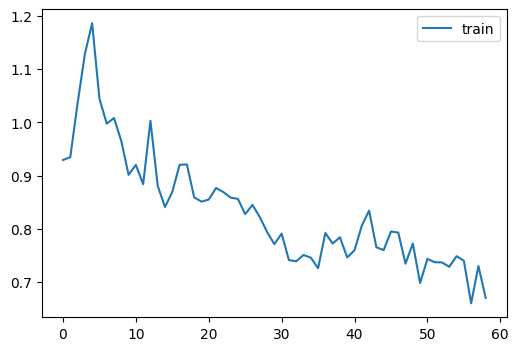

In [85]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = FlexibleLearner(
    model, dls, loss_func=F.cross_entropy, cbs=cbs,lr=0.2
    )
learn.fit(1)

## Momentum Learner

In [89]:
class MomentumLearner(FlexibleLearner):
	def __init__(self, model, dls, loss_func, cbs, opt_func=optim.SGD, lr=1e-1, mom=0.9):
		super().__init__(model, dls, loss_func, cbs, opt_func, lr)
		self.mom = mom
	def predict(self):
		self.preds = self.model(self.batch[0])
	def get_loss(self):
		self.loss = self.loss_func(self.preds, self.batch[1])
	def backward(self):
		self.loss.backward()
	def step(self):
		self.opt.step()
	def zero_grad(self):
		with torch.no_grad():
			for p in self.model.parameters():
				p.grad = p.grad * self.mom



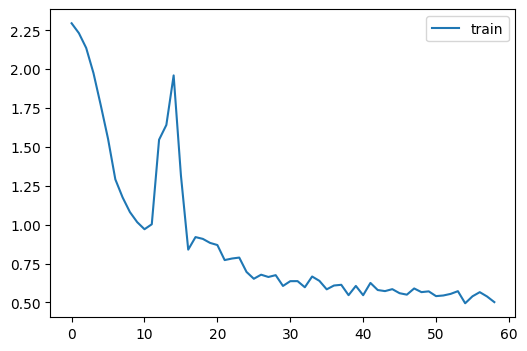

In [90]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(
    get_model(), dls, loss_func=F.cross_entropy, cbs=cbs, lr=0.2, mom=0.85)
learn.fit(1)


## LR Finder Callback

In [102]:
class LRFinderCB(CallBack):
	def __init__(
			self, 
			lr_mult=1.3):
		store_attr()

	def before_fit(self):
		self.lrs, self.losses = [], []
		self.min = math.inf

	def after_batch(self):
		if not self.learn.model.training: return CancelEpochException
		self.lrs.append(
			self.learn.opt.param_groups[0]['lr']
		)
		loss = to_cpu(self.learn.loss)
		self.losses.append(loss)
		if loss < self.min:
			self.min = loss
		else:
			if loss > self.min * 3:
				raise CancelFitException
		for g in self.learn.opt.param_groups: g['lr'] *= self.lr_mult
	
	def plot_(self):
		plt.plot(self.lrs, self.losses)
		plt.xscale('log')



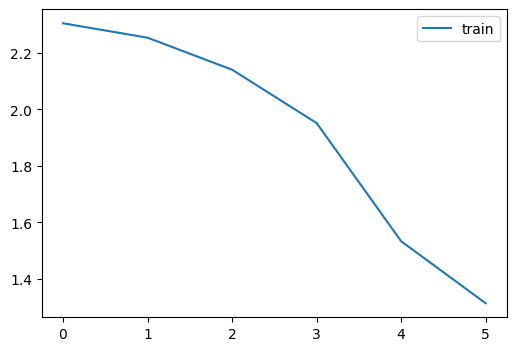

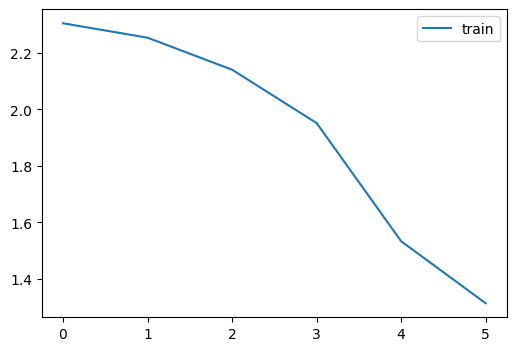

In [103]:
lrfind = LRFinderCB()
cbs = [DeviceCB(),metrics, ProgressCB(plot=True), lrfind]
learn = MomentumLearner(
    get_model(), dls, loss_func=F.cross_entropy, cbs=cbs, lr=0.2, mom=0.85)
learn.fit(1)


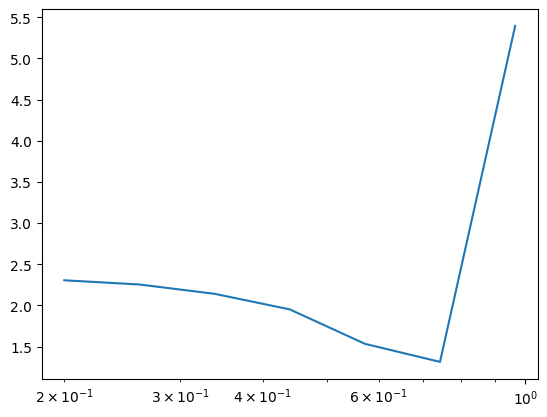

In [104]:
lrfind.plot_()

In [ ]:
class LRFinderPTLrScheduler(CallBack):
	def __init__(self, lr_mult=1.3): store_attr()
	def before_fit(self):
		self.lrs, self.losses = [], []
		self.min = math.inf


In [47]:
#| hide
import nbdev; nbdev.nbdev_export('02_preprocessing.lesson_16.ipynb')